In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re

# Load the data
df = pd.read_csv('prosumer_stats.csv')

# Function to parse the transactions string
def parse_transactions(trans_str):
    if pd.isna(trans_str):
        return []
    try:
        return ast.literal_eval(trans_str)
    except:
        return []

df['transactions_list'] = df['transactions'].apply(parse_transactions)

# Create a mapping of ID to Neighborhood for later use
id_to_hood = df.set_index('id')['neighbourhood'].to_dict()

df.head()

,hour,id,pv_capacity,pv_generation,load,battery_capacity,battery_level,imbalance,money_balance,trading_price,neighbourhood,bonus,penalty,p2p_exchanges,agg_exchanges,market_price,transactions,transactions_list
0,0,0,1.00,0.028106,0.183980,0,0.0,0.0,-19.001307,121.597602,Crocetta,1.0,1.0,0,1,116.096545,"[{'sender': 'Aggregator', 'receiver': 0, 'amou...","[{'sender': 'Aggregator', 'receiver': 0, 'amou..."
1,0,5,1.75,0.020369,0.284739,10,0.0,0.0,-32.227007,115.720744,Crocetta,1.0,1.0,0,1,116.096545,"[{'sender': 'Aggregator', 'receiver': 5, 'amou...","[{'sender': 'Aggregator', 'receiver': 5, 'amou..."
2,0,10,3.50,0.017571,0.217093,0,0.0,0.0,-24.321979,108.423407,Crocetta,1.0,1.0,0,1,116.096545,"[{'sender': 'Aggregator', 'receiver': 10, 'amo...","[{'sender': 'Aggregator', 'receiver': 10, 'amo..."
3,0,20,1.25,0.025185,0.254486,15,0.0,0.0,-27.952018,111.511634,Crocetta,1.0,1.0,0,1,116.096545,"[{'sender': 'Aggregator', 'receiver': 20, 'amo...","[{'sender': 'Aggregator', 'receiver': 20, 'amo..."
4,0,21,0.75,0.025342,0.236981,0,0.0,0.0,-25.799032,118.566465,Crocetta,1.0,1.0,0,1,116.096545,"[{'sender': 'Aggregator', 'receiver': 21, 'amo...","[{'sender': 'Aggregator', 'receiver': 21, 'amo..."


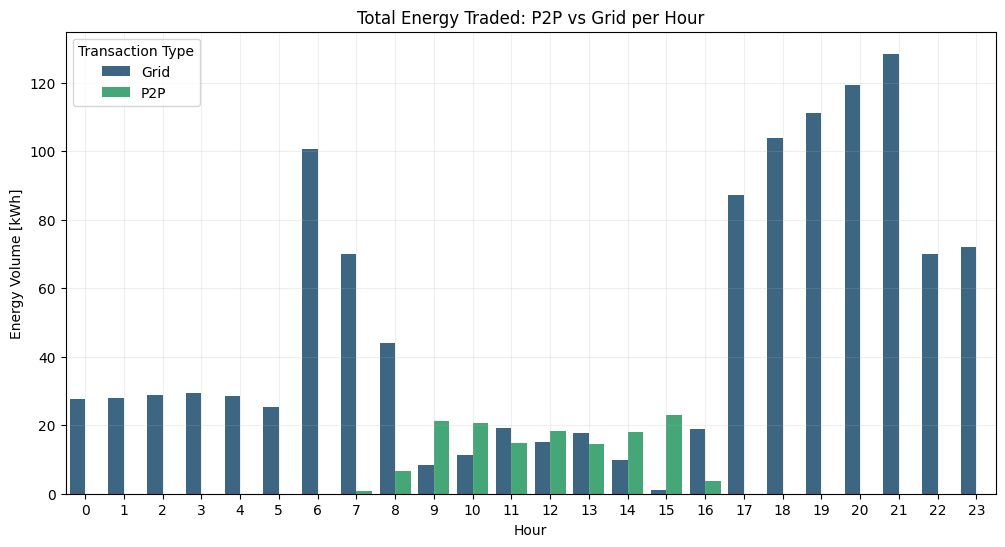

In [15]:
# Energy Flows (Global & Hourly)
# Visualize the total energy volume traded P2P vs. with the Grid/Aggregator per hour

# Aggregate transaction data
hourly_energy = {'hour': [], 'type': [], 'amount': []}

for index, row in df.iterrows():
    for t in row['transactions_list']:
        hourly_energy['hour'].append(t['hour'])
        if t['type'] == 'P2P':
            t_type = 'P2P'
        else:
            t_type = 'Grid'
        hourly_energy['type'].append(t_type)
        hourly_energy['amount'].append(t['amount'])

energy_df = pd.DataFrame(hourly_energy)
energy_summary = energy_df.groupby(['hour', 'type'])['amount'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=energy_summary, x='hour', y='amount', hue='type', palette='viridis')
plt.title('Total Energy Traded: P2P vs Grid per Hour')
plt.xlabel('Hour')
plt.ylabel('Energy Volume [kWh]')
plt.legend(title='Transaction Type')
plt.grid( alpha=0.2)
plt.show()

# Gemini comments:
# You will likely see P2P trading peak during daylight hours (e.g., 10:00 to 16:00) 
# when solar production is high. If the "Grid" bars are huge during the evening peak (18:00–21:00), 
# it means the community batteries/solar aren't enough to cover the night demand

# Success Indicator: If the P2P bars are visible and significant, your Step 2 (P2P Market) is working correctly.

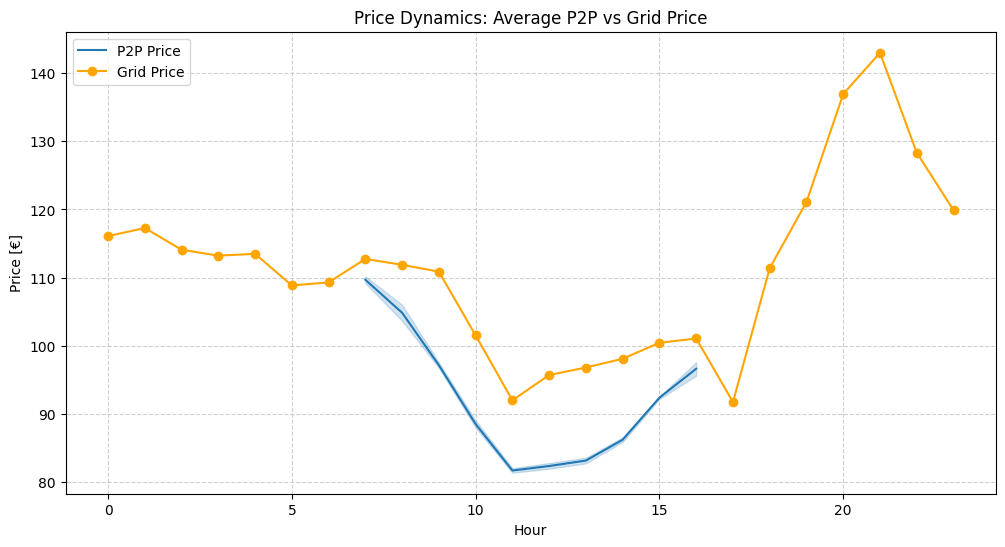

In [16]:
# Price Dynamics
# Compare the average P2P trading price against the Grid (Aggregator) price over time.
price_data = {'hour': [], 'price': [], 'market': []}

# 1. Get P2P Prices from transactions
for index, row in df.iterrows():
    for t in row['transactions_list']:
        if t['type'] == 'P2P':
            price_data['hour'].append(t['hour'])
            price_data['price'].append(t['price_per_kWh'])
            price_data['market'].append('P2P Price')

grid_prices = df['market_price'].groupby(df['hour']).mean().tolist()

price_df = pd.DataFrame(price_data)

plt.figure(figsize=(12, 6))
sns.lineplot(data=price_df, x='hour', y='price', markers=True, dashes=False , label='P2P Price')
plt.plot(range(24), grid_prices, label='Grid Price', marker='o' , color='orange')
plt.title('Price Dynamics: Average P2P vs Grid Price')
plt.xlabel('Hour')
plt.ylabel('Price [€]')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Gemini comments:

# Economic Incentive: For P2P trading to be attractive, the P2P price line should generally be lower than the Grid Buy price 
# (what consumers pay the aggregator) and higher than the Grid Sell price (what producers get from the aggregator).

# Market Behavior: If the P2P price fluctuates (e.g., drops during the day when there is excess solar, rises at night), 
# it shows your market mechanism is responsive to supply and demand.

# Anomaly Check: If the P2P price is identical to the grid price, your pricing mechanism might be static or not functioning dynamically.

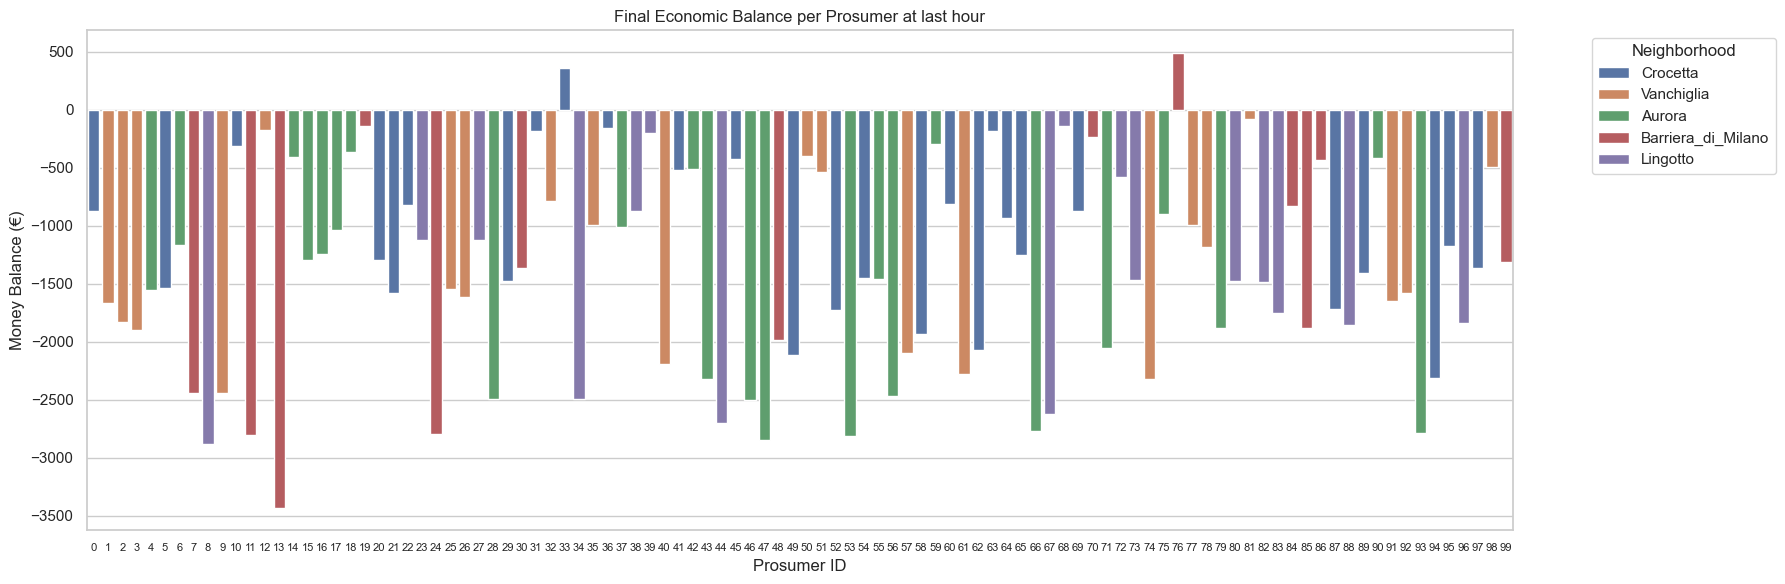

In [42]:
# Prosumer Economic Outcomes
# Show who made money and who lost money by the end of the simulation.

# final state (last hour) for each prosumer
last_hour = df['hour'].max()
final_stats = df[df['hour'] == last_hour].sort_values('money_balance')

plt.figure(figsize=(18, 6))
# color bars by neighborhood
sns.barplot(data=final_stats, x='id', y='money_balance', hue='neighbourhood', dodge=False)
plt.title(f'Final Economic Balance per Prosumer at last hour')
plt.xlabel('Prosumer ID')
plt.ylabel('Money Balance (€)')
plt.xticks(fontsize=8)
plt.legend(title='Neighborhood', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Gemini comments:
# Winners vs. Losers: Prosumers with high PV generation and batteries usually end up with positive bars (profit). 
# Pure consumers (no PV) will have negative bars (expenses).

# Neighborhood Trends: Since the bars are colored by neighborhood, check if specific neighborhoods 
# (e.g., "Crocetta" or "Vanchiglia") are performing better. This might indicate that one neighborhood
# has better solar exposure or battery capacity in your simulation setup.

# Outliers: If one bar is massive compared to others, that agent might have huge capacity or
# be capitalizing on the market disproportionately.

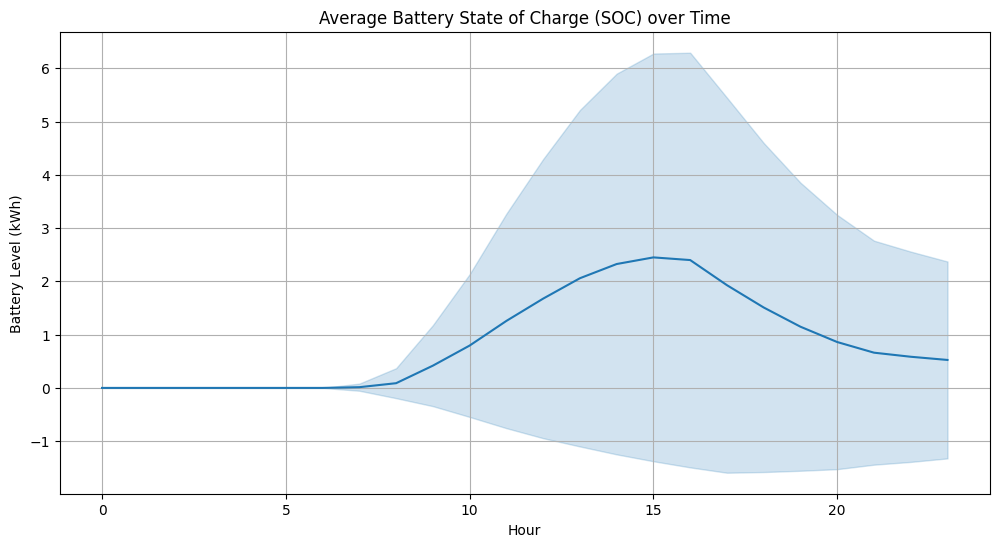

In [18]:
# Plotting average battery level with range (min-max)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='hour', y='battery_level', errorbar='sd') # sd = standard deviation
plt.title('Average Battery State of Charge (SOC) over Time')
plt.xlabel('Hour')
plt.ylabel('Battery Level (kWh)')
plt.grid(True)
plt.show()

# Gemini comments:
# Cycling: You should see a curve that starts low, 
# rises during the day (charging from solar), peaks around 14:00–16:00, and drops in the evening (discharging to support consumption).

# Utilization: If the line is flat near 0 or flat near 100% capacity, the batteries aren't being used effectively.

# Variability: Large error bars indicate that some prosumers are fully charged while others are empty, 
# suggesting an uneven distribution of resources.

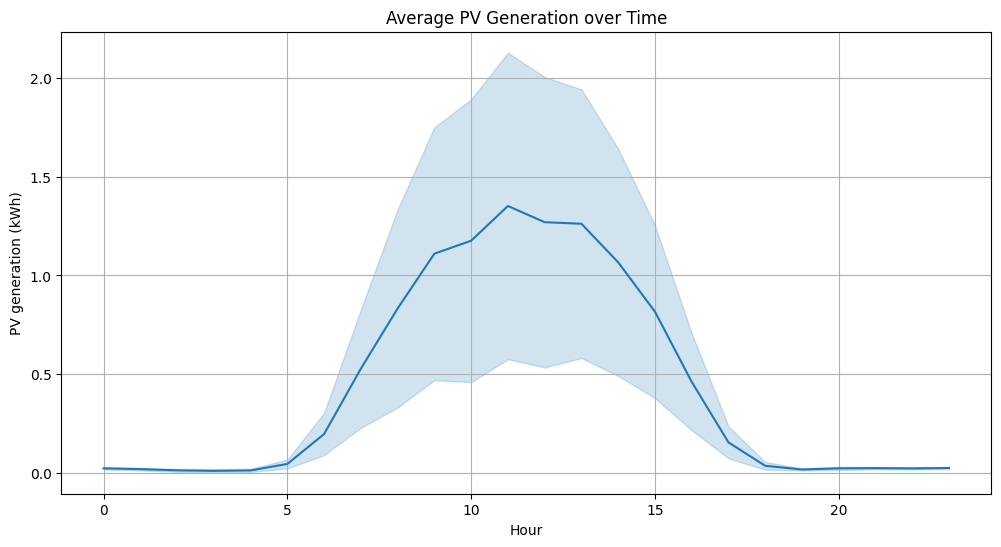

In [19]:
# Plotting average PV generation with range (min-max)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='hour', y='pv_generation', errorbar='sd') # sd = standard deviation
plt.title('Average PV Generation over Time')
plt.xlabel('Hour')
plt.ylabel('PV generation (kWh)')
plt.grid(True)
plt.show()

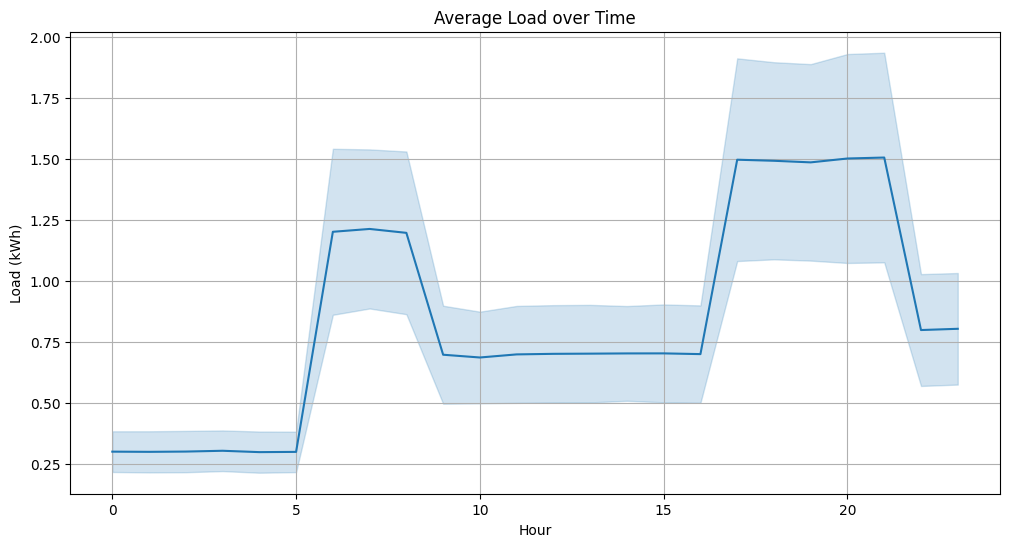

In [20]:
# Plotting average load with range (min-max)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='hour', y='load', errorbar='sd') # sd = standard deviation
plt.title('Average Load over Time')
plt.xlabel('Hour')
plt.ylabel('Load (kWh)')
plt.grid(True)
plt.show()

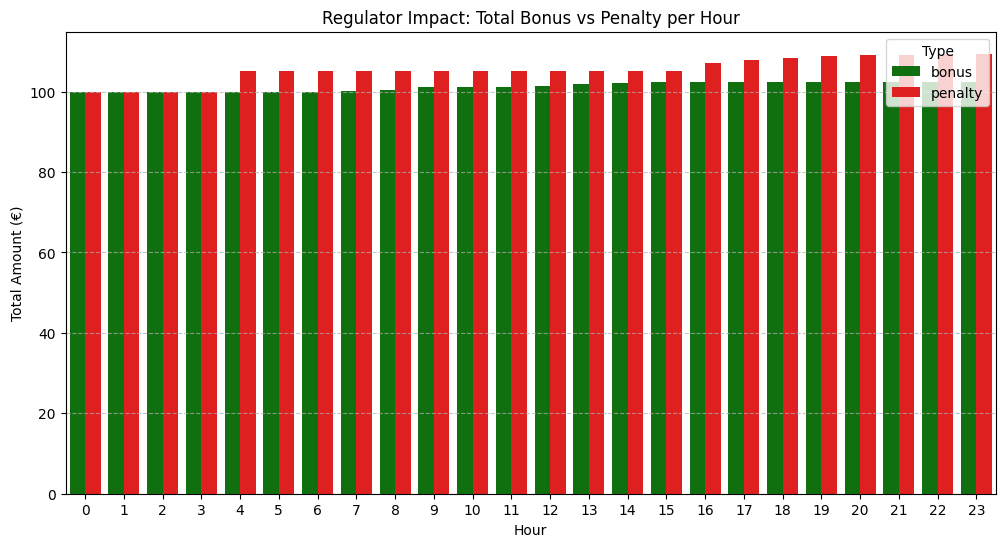

In [21]:
# Regulator Impact (Bonus vs Penalty)
# Visualize the financial incentives applied by the regulator

# Sum bonuses and penalties per hour
regulator_stats = df.groupby('hour')[['bonus', 'penalty']].sum().reset_index()
# Melt for plotting
regulator_melted = regulator_stats.melt('hour', var_name='Type', value_name='Amount')

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=regulator_melted, x='hour', y='Amount', hue='Type', palette=['green', 'red'])
plt.title('Regulator Impact: Total Bonus vs Penalty per Hour')
plt.xlabel('Hour')
plt.ylabel('Total Amount (€)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Gemini comments:
# Rule Compliance:

# - High Penalties: This means prosumers are deviating significantly 
#       from their promised profiles (Step 1 prediction vs. Step 3 actuals). This suggests the prediction models might 
#       be inaccurate or the battery balancing logic isn't aggressive enough.

#  - High Bonuses: This means prosumers are helping the grid (e.g., increasing consumption when there is a surplus).

# Regulator Strategy: This plot confirms if the "Regulator" agent code is actually triggering and applying financial consequences as intended.

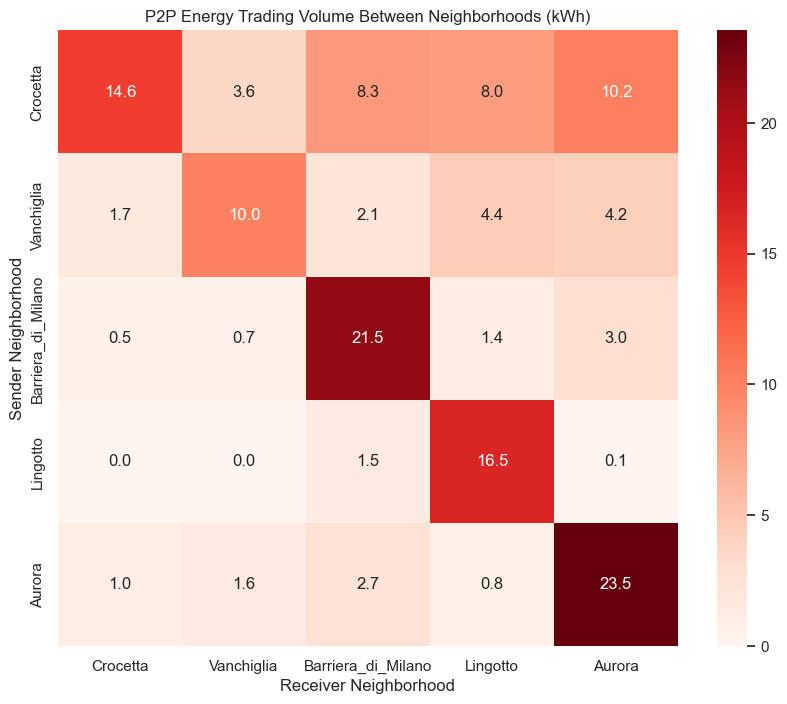

In [28]:
# Neighborhood Trading Heatmap
# See which neighborhoods are trading with each other (P2P)

neighborhoods = df['neighbourhood'].unique()
# Create a square DataFrame initialized with zeros
trade_matrix = pd.DataFrame(0.0, index=neighborhoods, columns=neighborhoods)

# Fill matrix with P2P trade volumes
for index, row in df.iterrows():
    sender_hood = row['neighbourhood']
    transactions = row['transactions_list']
    
    for t in transactions:
        if t['type'] == 'P2P':
            receiver_id = t['receiver']
            amount = t['amount']
            
            # Find receiver's neighborhood
            if receiver_id in id_to_hood:
                receiver_hood = id_to_hood[receiver_id]
                # Add to matrix (Rows = Senders, Cols = Receivers)
                trade_matrix.loc[sender_hood, receiver_hood] += amount

plt.figure(figsize=(10, 8))
sns.heatmap(trade_matrix, annot=True, cmap='Reds', fmt='.1f')
plt.title('P2P Energy Trading Volume Between Neighborhoods (kWh)')
plt.xlabel('Receiver Neighborhood')
plt.ylabel('Sender Neighborhood')
plt.show()

# Gemini comments:
# Diagonal: The diagonal squares (e.g., Centro to Centro) show energy traded within the same neighborhood. This is often highest.

# Community Integration: Bright colors off the diagonal (e.g., Crocetta to Vanchiglia) prove that the "Smart City" concept 
# is working—energy is being shared across the entire city, not just within isolated pockets.

# Exporters vs. Importers: If a row is very dark (high values), that neighborhood is a net producer (exporting energy). 
# If a column is dark, that neighborhood is a net consumer (importing energy).

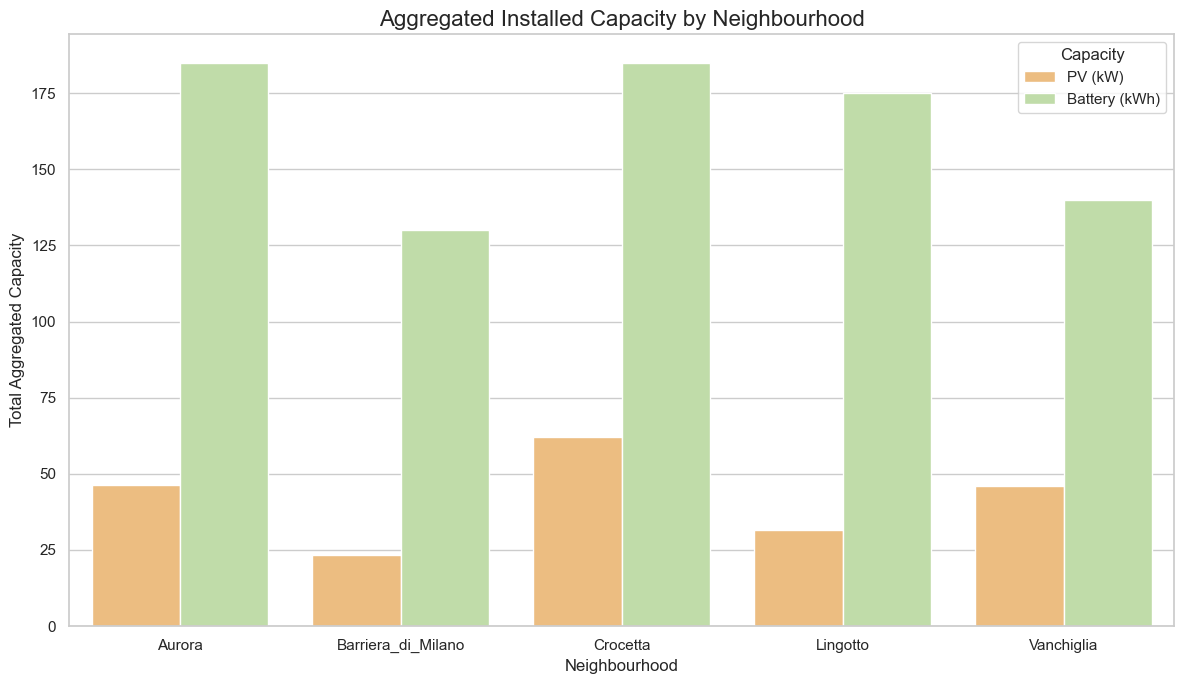

In [38]:
# Neighbourhood Statistics Plotting

# Step 1: Calculate the average capacity per prosumer ID
prosumer_stats = df.groupby('id')[['pv_capacity', 'battery_capacity']].mean().reset_index()

# Step 2: Map the neighbourhood back to the prosumer ID
id_to_neighbourhood = df[['id', 'neighbourhood']].drop_duplicates().set_index('id')['neighbourhood'].to_dict()
prosumer_stats['neighbourhood'] = prosumer_stats['id'].map(id_to_neighbourhood)

# Step 3: Sum the total installed capacity per neighbourhood
agg_stats = prosumer_stats.groupby('neighbourhood')[['pv_capacity', 'battery_capacity']].sum().reset_index()

# --- Plotting ---

# Melt the dataframe for easier plotting with seaborn
plot_df = agg_stats.melt(
    id_vars='neighbourhood', 
    var_name='Capacity', 
    value_name='Value'
)

# Rename metrics
plot_df['Capacity'] = plot_df['Capacity'].replace({
    'pv_capacity': 'PV (kW)',
    'battery_capacity': 'Battery (kWh)'
})

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

# Create the grouped bar chart
sns.barplot(
    x='neighbourhood', 
    y='Value', 
    hue='Capacity', 
    data=plot_df,
    palette='Spectral'
)

# Customize the plot
plt.title('Aggregated Installed Capacity by Neighbourhood', fontsize=16)
plt.xlabel('Neighbourhood', fontsize=12)
plt.ylabel('Total Aggregated Capacity', fontsize=12)
plt.legend(title='Capacity', loc='upper right')
plt.tight_layout() 
plt.show()

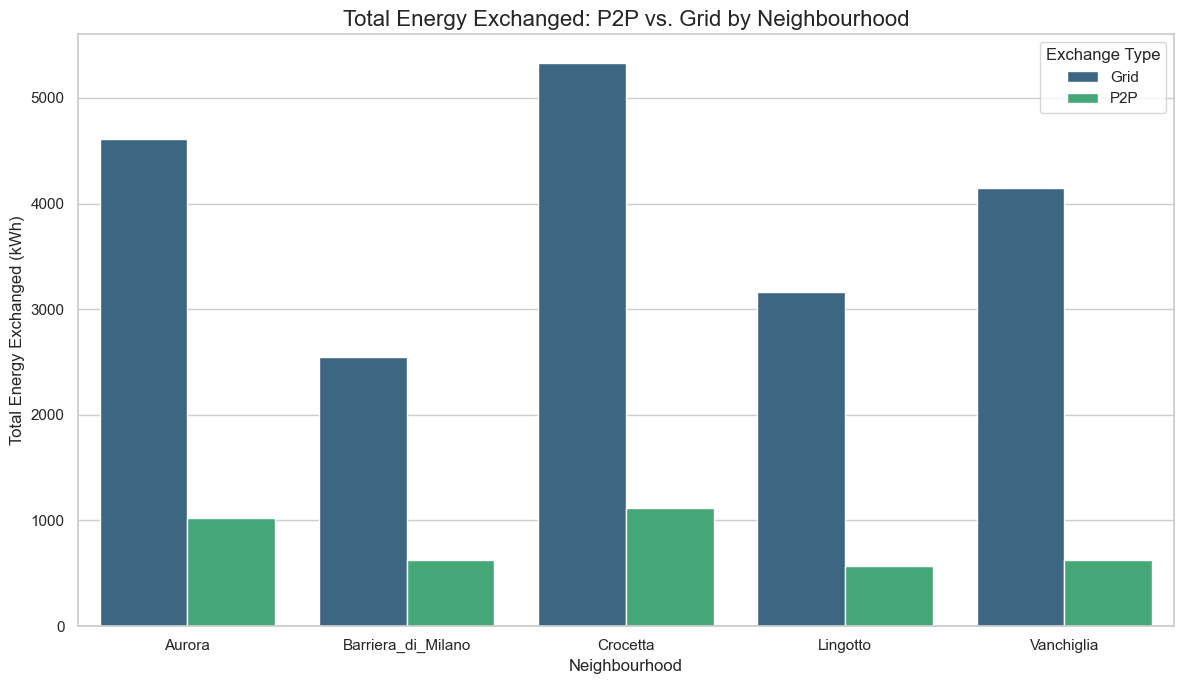

In [39]:
# Neighbourhood Energy Exchange Plotting

# 1. Aggregate the total exchanges by Neighbourhood
# Summing across all hours and prosumers in the neighborhood
exchange_stats = df.groupby('neighbourhood')[['agg_exchanges', 'p2p_exchanges']].sum().reset_index()

# 2. Melt the dataframe for plotting
plot_df_exchange = exchange_stats.melt(
    id_vars='neighbourhood', 
    var_name='Exchange Type', 
    value_name='Energy Exchanged (kWh)'
)

# 3. Rename metrics
plot_df_exchange['Transaction Type'] = plot_df_exchange['Exchange Type'].replace({
    'agg_exchanges': 'Grid',
    'p2p_exchanges': 'P2P'
})

# --- Plotting ---
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

sns.barplot(
    x='neighbourhood', 
    y='Energy Exchanged (kWh)', 
    hue='Transaction Type', 
    data=plot_df_exchange,
    palette='viridis'
)

# Customize the plot
plt.title('Total Energy Exchanged: P2P vs. Grid by Neighbourhood', fontsize=16)
plt.xlabel('Neighbourhood', fontsize=12)
plt.ylabel('Total Energy Exchanged (kWh)', fontsize=12)
plt.legend(title='Exchange Type', loc='upper right')
plt.tight_layout() 
plt.show()